In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from sklearn.naive_bayes import GaussianNB
from sklearn.compose import ColumnTransformer
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, OrdinalEncoder, StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, StratifiedKFold
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, classification_report

In [2]:
!unzip adult.zip

Archive:  adult.zip
  inflating: Index                   
  inflating: adult.data              
  inflating: adult.names             
  inflating: adult.test              
  inflating: old.adult.names         


In [5]:
cols = [
    "age","workclass","fnlwgt","education","education_num",
    "marital_status","occupation","relationship","race","sex",
    "capital_gain","capital_loss","hours_per_week",
    "native_country","income"
]

train_df = pd.read_csv("adult.data", names=cols, sep=",", skipinitialspace=True)
test_df  = pd.read_csv("adult.test", names=cols, sep=",", skipinitialspace=True, skiprows=1)
test_df["income"] = test_df["income"].str.replace(".", "", regex=False)

df = pd.concat([train_df, test_df], ignore_index=True)
for col in df.select_dtypes(include="object").columns:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])

X = df.drop("income", axis=1)
y = df["income"]

X = df.drop(["income", "fnlwgt", "education"], axis=1)

In [6]:
X_train = X.iloc[:len(train_df)]
X_test = X.iloc[len(train_df):]
y_train = y.iloc[:len(train_df)]
y_test = y.iloc[len(train_df):]

scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

**Fit and predict**

In [7]:
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_scaled, y_train)

model = GaussianNB()
model.fit(X_train_resampled, y_train_resampled)

y_pred = model.predict(X_test_scaled)
y_pred_prob = model.predict_proba(X_test_scaled)[:, 1]

In [8]:
print("Accuracy :", round(accuracy_score(y_test, y_pred), 4))
print("Precision:", round(precision_score(y_test, y_pred), 4))
print("Recall   :", round(recall_score(y_test, y_pred), 4))
print("F1-score :", round(f1_score(y_test, y_pred), 4))

print("\nClassification report:\n", classification_report(y_test, y_pred))

Accuracy : 0.8199
Precision: 0.675
Recall   : 0.4579
F1-score : 0.5456

Classification report:
               precision    recall  f1-score   support

           0       0.85      0.93      0.89     12435
           1       0.67      0.46      0.55      3846

    accuracy                           0.82     16281
   macro avg       0.76      0.69      0.72     16281
weighted avg       0.81      0.82      0.81     16281



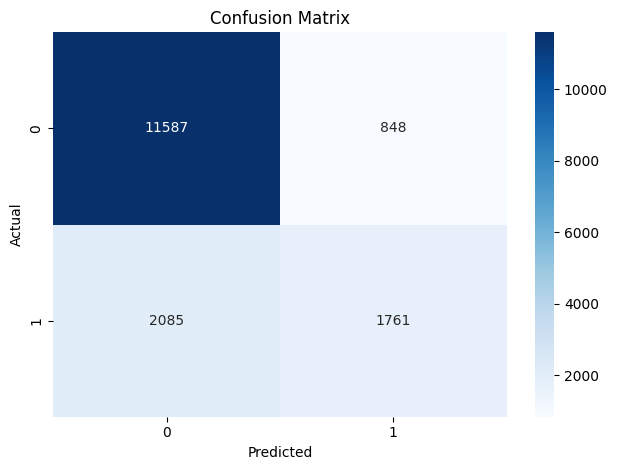

In [9]:
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()

In [10]:
roc_auc = roc_auc_score(y_test, y_pred_prob)
print("ROC-AUC :", round(roc_auc, 4))

ROC-AUC : 0.8547


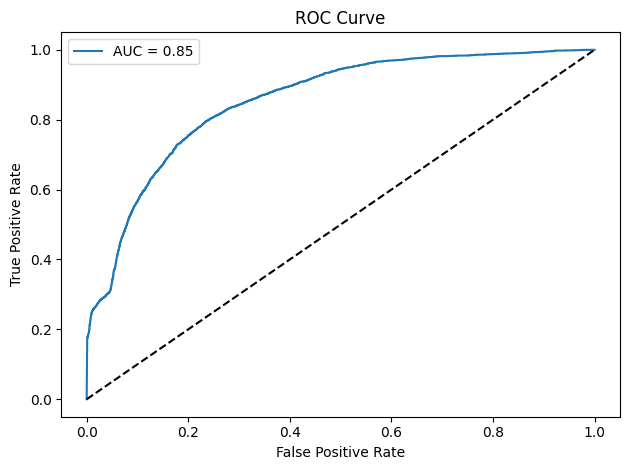

In [11]:
fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.2f}")
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.tight_layout()
plt.show()

**10 - fold cross-validation**

In [12]:
X_full = pd.concat([X_train, X_test], ignore_index=True)
y_full = pd.concat([y_train, y_test], ignore_index=True)

cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
cv_scores = cross_val_score(GaussianNB(), X_full, y_full, cv=cv, scoring="accuracy")

print("Cross-val mean accuracy :", round(cv_scores.mean(), 4))
print("         Accuracy range :", f"{cv_scores.min():.4f} – {cv_scores.max():.4f}")

Cross-val mean accuracy : 0.7991
         Accuracy range : 0.7920 – 0.8061


**Null accuracy comparison**

In [13]:
null_accuracy = y_test.value_counts(normalize=True).max()
print("Null accuracy:", round(null_accuracy, 4))

Null accuracy: 0.7638
